# Three-Qubit Repetition Code

In this notebook, we explore one of the simplest examples of a **quantum error correction (QEC) code**:  
the **three-qubit repetition code**. This code is designed to protect quantum information against single bit-flip ($X$) errors.

---

## Encoding

The idea is simple: instead of storing a logical qubit in a single physical qubit, we **encode** it into three qubits.  

- Logical $|0_L\rangle = |000\rangle$  
- Logical $|1_L\rangle = |111\rangle$  

For example, if the input qubit is in a superposition $\alpha|0\rangle + \beta|1\rangle$, then after encoding we obtain:  

$$
\alpha |000\rangle + \beta |111\rangle .
$$

This redundancy allows us to detect and correct errors by comparing the qubits.

---

## Error Model

After encoding, we assume that **each physical qubit** independently undergoes a bit-flip ($X$) error with probability $p$.  
In this file, we specifically consider a single error layer applied **immediately after encoding**.

---

## Syndrome Extraction

To diagnose where an error may have occurred, we measure **parity checks** (syndromes):  

- $Z_0 Z_1$ compares qubits 0 and 1.  
- $Z_1 Z_2$ compares qubits 1 and 2.  

The results tell us whether neighboring qubits agree or disagree.  
From this two-bit syndrome, we can uniquely identify which qubit (if any) has flipped.  

---

## Error Correction

Once we know the syndrome, we apply a correction:  

- If the syndrome points to qubit 0, flip qubit 0.  
- If it points to qubit 1, flip qubit 1.  
- If it points to qubit 2, flip qubit 2.  

After correction, the three qubits are restored to the code space.  
Finally, we can recover the logical qubit by a **majority vote**: if at least two of the three qubits are $|0\rangle$, we decode as $|0\rangle$; if at least two are $|1\rangle$, we decode as $|1\rangle$.

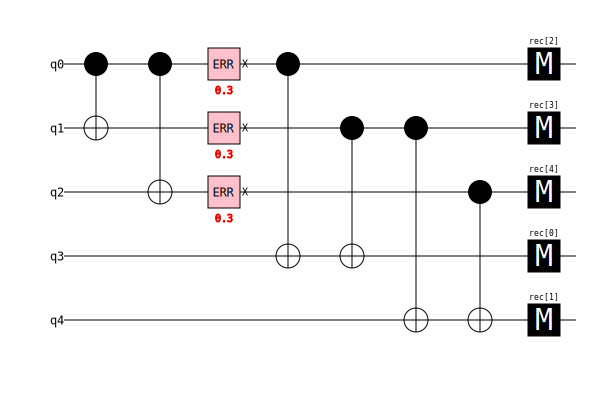

In [6]:
import stim
import pymatching as pm
import numpy as np
from IPython.display import SVG, display, Math
import matplotlib.pyplot as plt
from typing import Counter
import sys, os; sys.path.append(os.path.abspath(".."))

# --- Parameters ---
chance = 0.3

# --- Build circuit (|0_L> for the 3-qubit repetition code) ---
circuit = stim.Circuit()
circuit.append("CNOT", [0, 1])         # encode: copy data 0 -> 1,2
circuit.append("CNOT", [0, 2])

# noise on data qubits (after encoding)
circuit.append("X_ERROR", [0, 1, 2], chance)

# parity checks onto ancillas q3 (for 0⊕1) and q4 (for 1⊕2)
circuit.append("CNOT", [0, 3])
circuit.append("CNOT", [1, 3])
circuit.append("CNOT", [1, 4])
circuit.append("CNOT", [2, 4])

# measure all qubits
circuit.append("M", [3,4,0,1,2])

# Show circuit diagram as SVG
SVG(str(circuit.diagram("timeline")))

## Simulation Results

In this part, we run the three-qubit repetition code circuit $10^6$ times under independent bit-flip noise with probability $p = 0.3$.  

- The **raw physical error rate** is $0.3$.  
- After encoding, syndrome extraction, and correction, the **logical error rate** drops to about $0.22$.  

The histograms below summarize the outcomes:

- **Syndrome histogram**: shows how often each two-bit syndrome $(s_{01}, s_{12})$ was reported.  
- **Error pattern histogram**: shows the distribution of actual error events on the data qubits, from no error ($I$) to single, double, and triple flips.  

These plots illustrate both how the code diagnoses errors through syndromes and how redundancy suppresses the logical error rate compared to the raw physical error rate.

Logical error rate (shots=1000000, pX=0.3): 0.215959


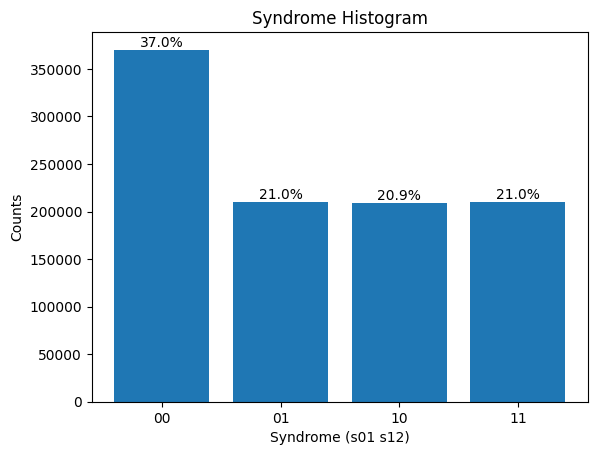

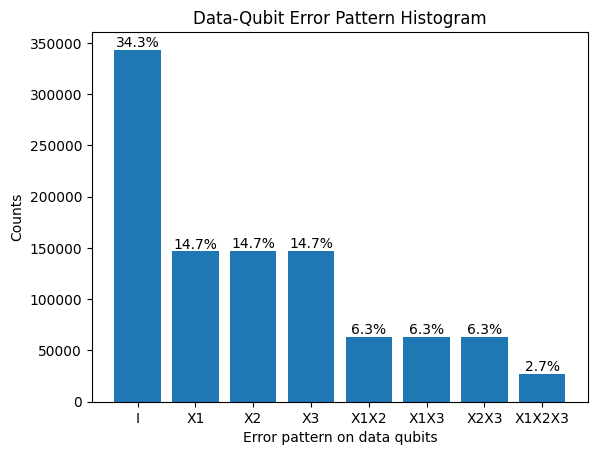

In [7]:
shots = 1_000_000

# --- Sample ---
samp = circuit.compile_sampler().sample(shots=shots).astype(np.uint8)
s01 = samp[:, 0]  # parity of (q0,q1)
s12 = samp[:, 1]  # parity of (q1,q2)
d0  = samp[:, 2]
d1  = samp[:, 3]
d2  = samp[:, 4]

flip0 = (s01 == 1) & (s12 == 0)
flip1 = (s01 == 1) & (s12 == 1)
flip2 = (s01 == 0) & (s12 == 1)

d0c = d0 ^ flip0.astype(np.uint8)
d1c = d1 ^ flip1.astype(np.uint8)
d2c = d2 ^ flip2.astype(np.uint8)

# --- Decode logical bit (majority vote on corrected data) ---
sum_bits = d0c + d1c + d2c
decoded_logical = (sum_bits >= 2).astype(np.uint8)  # majority: 0/1

# We encoded |0_L>, so a logical error is when decoded == 1
logical_error_rate = decoded_logical.mean()

print(f"Logical error rate (shots={shots}, pX={chance}): {logical_error_rate:.6f}")

# Optional: quick sanity peek at syndrome distribution
pairs = np.stack([s01, s12], axis=1).astype(int)
syndrome_counts = Counter(map(tuple, pairs.tolist()))  # tolist() makes rows pure Python ints

# Map syndrome pairs to string labels
syndrome_map = {(0,0): "00", (0,1): "01", (1,0): "10", (1,1): "11"}

# Count occurrences of each syndrome from your `pairs`
syndrome_str_counts = Counter(syndrome_map[tuple(pair)] for pair in pairs.tolist())

# Ensure consistent order of bars
labels = ["00", "01", "10", "11"]
counts = [syndrome_str_counts.get(l, 0) for l in labels]

# Total for percentage calculation
total = sum(counts)
percentages = [100 * c / total for c in counts]

# Plot histogram
bars = plt.bar(labels, counts)
plt.xlabel("Syndrome (s01 s12)")
plt.ylabel("Counts")
plt.title("Syndrome Histogram")

# Add percentages on top of bars
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x position (center of bar)
        height,                             # y position (top of bar)
        f"{pct:.1f}%",                      # label text
        ha='center', va='bottom'
    )

plt.show()

# --- Decode error patterns ---
codes = (d0.astype(int) + 2*d1.astype(int) + 4*d2.astype(int))
hist = np.bincount(codes, minlength=8)

labels = ["I", "X1", "X2", "X3", "X1X2", "X1X3", "X2X3", "X1X2X3"]
order  = [0,    1,    2,    4,    3,      5,      6,      7]  # indices in 'hist'
counts = [int(hist[i]) for i in order]
total  = sum(counts)
pct    = [100*c/total for c in counts]

# Plot
bars = plt.bar(labels, counts)
plt.xlabel("Error pattern on data qubits")
plt.ylabel("Counts")
plt.title("Data-Qubit Error Pattern Histogram")

# Percentage annotations
for b, p in zip(bars, pct):
    h = b.get_height()
    plt.text(b.get_x()+b.get_width()/2, h, f"{p:.1f}%", ha="center", va="bottom")

plt.show()

## Logical Error Rate of the Three-Qubit Repetition Code

In the following code, we simulate the performance of the three-qubit repetition code under independent bit-flip noise.  
The circuit is executed many times while varying the physical error probability $p$ between 0.01 and 0.99.  
For each value of $p$, we estimate the logical error rate using majority-vote decoding after syndrome correction.  
We then compare the simulated results to the analytical expression

$$
P_L(p) = 3p^2(1-p) + p^3,
$$

which gives the probability that two or more qubits flip and the code fails.  
The results are plotted as logical error rate versus physical error rate.


In [12]:
from src import three_qubit_code

# --- Sweep over probabilities ---
shots = 50_000   # adjust for precision/speed tradeoff
phys_errs = np.arange(0.01, 1.0, 0.02)  # 0.01, 0.03, ..., 0.99
logical_errs = []

for p in phys_errs:
    L = three_qubit_code(p, shots)
    logical_errs.append(L)

# --- Analytical curve ---
p_vals = np.linspace(0, 1, 200)
logical_theory = 3 * (p_vals**2) * (1 - p_vals) + (p_vals**3)

# --- Plot ---
plt.plot(phys_errs, logical_errs,
         marker="o", markersize=4, linestyle="None", label="Simulation")
plt.plot(p_vals, logical_theory,
         color="black", linewidth=1.5,
         label=r"Analytical $P_L(p) = 3p^2(1-p) + p^3$")
plt.plot(p_vals, p_vals,
         linestyle="--", color="orange", label="$y=x$ (no protection)")

plt.xlabel("Physical error rate $p$")
plt.ylabel("Logical error rate $P_L$")
plt.title("Three-Qubit Repetition Code Performance")
plt.legend()
plt.grid(True)
plt.show()

ImportError: cannot import name 'three_qubit_code' from 'src' (c:\Users\msokh\Quantum-Error-Correction\src\__init__.py)

## Summary

Through simulation we saw how the three-qubit repetition code uses redundancy and syndrome extraction to correct single bit-flip errors.  
Histograms of syndromes and data-qubit errors matched the expected theoretical distributions, confirming the role of parity checks in locating errors.  
By sweeping the physical error probability $p$, we found that the logical error rate agrees with the analytical expression  

$$
P_L(p) = 3p^2(1-p) + p^3,
$$  

and observed that the code suppresses errors when $p$ is small but eventually fails once multiple flips become likely.